In [1]:
!ls ../caueeg/

abnormal-no-overlap.json annotation.xlsx          dementia.json
abnormal.json            conn_data                event
annotation.json          dementia-no-overlap.json signal


In [2]:
import json
f = open('../caueeg/abnormal.json')
data_files = json.load(f)
f.close()

In [3]:
data_files["train_split"][0]

{'serial': '01258',
 'age': 77,
 'symptom': ['dementia', 'vd', 'sivd'],
 'class_name': 'Abnormal',
 'class_label': 1}

In [4]:
idx2label = {}
for file_idx in data_files["train_split"]:
    idx2label[file_idx["serial"]] = file_idx["class_label"]
for file_idx in data_files["test_split"]:
    idx2label[file_idx["serial"]] = file_idx["class_label"]
for file_idx in data_files["validation_split"]:
    idx2label[file_idx["serial"]] = file_idx["class_label"]

In [5]:
len(data_files["train_split"])

1107

In [6]:
len(data_files["test_split"])

136

In [7]:
len(data_files["validation_split"])

136

In [8]:
import glob, os
files = []
for file in glob.glob("../caueeg/signal/edf/*.edf"):
    files.append(file)
print(len(files))

1379


In [9]:
import glob, os
test_data_files = []
for file_name in data_files["test_split"]:
    test_data_files.append("../caueeg/signal/edf/"+file_name["serial"]+".edf")
print(len(test_data_files))

train_data_files = []
for file_name in data_files["train_split"]:
    train_data_files.append("../caueeg/signal/edf/"+file_name["serial"]+".edf")
for file_name in data_files["validation_split"]:
    train_data_files.append("../caueeg/signal/edf/"+file_name["serial"]+".edf")
print(len(train_data_files))

136
1243


In [10]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.modules.module import Module
from sklearn.preprocessing import OneHotEncoder

/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import mne
import numpy as np

file = train_data_files[0]
data = mne.io.read_raw(file, verbose=False, preload=True)

data.filter(l_freq=0.5, h_freq=47, verbose=False)
ch_names = data.ch_names
data = data.get_data()*1e6
data.shape

(21, 183400)

In [13]:
import mne
from tqdm import tqdm
from statsmodels.tsa.stattools import grangercausalitytests
import random
import numpy as np
from scipy.signal import savgol_filter
from scipy import signal
import cv2
from numpy import *
from scipy.stats import iqr
from scipy.integrate import simps
from scipy.stats import entropy
from scipy.signal import medfilt
from scipy.stats import differential_entropy, norm
from scipy import fftpack
import antropy as ant


def calcGrangerCausality(eegData,ii,jj):
    #eegData = np.diff(eegData)
    gc_avg = []
    for epoch_idx, epoch in enumerate(eegData):
        if epoch_idx%2 == 0:
            X = np.vstack([epoch[ii,:],epoch[jj,:]]).T
            gc = grangercausalitytests(X, 1, addconst=True, verbose=False)[1][0]['ssr_ftest'][0]
            gc_avg.append(gc)
    gc_avg = np.mean(gc_avg)
    return gc_avg

def get_label(file):
    idx = file.split("/")[-1][:-4]
    label = idx2label[idx]
    if label == 0:
        return [0]
    elif label == 1:
        return [1]


def lyapunov(x):
    return np.mean(np.log(np.abs(np.gradient(x))))


def build_data(raw_data, bands=False):
    
    eeg_data = []
    labels = []
    lengths = []
    groups = []
    i = 0
    fs = 100
    
    data_features = []
    data_labels = []
    data_graphs = []
    
    for file in tqdm(raw_data):
        
        #get label
        label = get_label(file)
        data_labels.append(label)
        
        #node features
        sample_features = []
        data = mne.io.read_raw(file, verbose=False, preload=True)
        ch_names = data.ch_names
        #data.resample(sfreq=100)
        data.filter(l_freq=0.5, h_freq=40, verbose=False).resample(sfreq=fs)
        data_epochs = mne.make_fixed_length_epochs(data, duration=1, overlap=0, verbose=False)
        data = data.get_data()
        data_epochs = data_epochs.get_data()
        if data_epochs.shape[0] > 20:
            data_epochs = data_epochs[:20]

        gc = []
        for i in range(21):
            gc1 = []
            for j in range(21):
                gc1.append(calcGrangerCausality(data_epochs, i, j))
            gc.append(gc1)
        data_graphs.append(gc)    
        
        
        ch_features = []    
        # freq domain features
        sf = 256
        win = 4 * sf # win size 4 seconds * sampling freq
        # delta (0.5–4 Hz), theta (4–8 Hz), alpha (8–13 Hz), beta (13–30 Hz), and gamma (30–... Hz).
        freq_ranges = [[0.5, 4], [4, 8], [8, 13], [13, 30], [30, 47]]
        for ch in data:
            
            ch_features.append(differential_entropy(ch))
        
            ly = lyapunov(ch)
            #ch_features.append(ly)
        
            entropy = ant.perm_entropy(ch, normalize=True)
            ch_features.append(entropy)
        
            entropy = ant.spectral_entropy(ch, sf=100, method='welch', normalize=True)
            ch_features.append(entropy)
        
            mobility = ant.hjorth_params(ch)
            ch_features.append(mobility[0])
            ch_features.append(mobility[1])
        
            zero_cross_count = ant.num_zerocross(ch)
            ch_features.append(zero_cross_count)
            
            
            if bands:
                # freq domain features
                for freq_band in freq_ranges:
                
                    # differential entropy
                    sos = signal.butter(10, (freq_band[0], freq_band[1]), 'bandpass', fs=1000, output='sos')
                    filtered_ch = signal.sosfilt(sos, ch) 
                    ch_features.append(differential_entropy(filtered_ch))

                    # lyapunov features
                    ch_features.append(lyapunov(filtered_ch))

                    # Permutation entropy
                    entropy = ant.perm_entropy(filtered_ch, normalize=True)
                    ch_features.append(entropy)

                    # Spectral entropy
                    entropy = ant.spectral_entropy(filtered_ch, sf=100, method='welch', normalize=True)
                    ch_features.append(entropy)

                    # Hjorth mobility and complexity
                    mobility = ant.hjorth_params(filtered_ch)
                    ch_features.append(mobility[0])
                    ch_features.append(mobility[1])

                    corr = np.correlate(filtered_ch, filtered_ch)
                    ch_features.append(corr[0])

                    # Number of zero-crossings
                    zero_cross_count = ant.num_zerocross(filtered_ch)
                    ch_features.append(zero_cross_count)

                    # power spectrum
                    freqs, psd = signal.welch(ch, sf, nperseg=win)
                    idx_freq_band = np.logical_and(freqs >= freq_band[0], freqs < freq_band[1])
                    # Frequency resolution
                    freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25
                    # Compute the absolute power by approximating the area under the curve
                    band_power = simps(psd[idx_freq_band], dx=freq_res)
                    #power_band_.append(band_power)
                    ch_features.append(band_power)
                
            
            sample_features.append(ch_features)
            ch_features = []
            
        data_features.append(sample_features)
        
    data_features = np.array(data_features)
    data_labels = np.array(data_labels)
    data_graphs = np.array(data_graphs)
    
    return data_features, data_graphs, data_labels

In [79]:
%%capture
np.random.seed(42)
#train_X, train_graphs, train_y = build_data(train_data_files)
#test_X, test_graphs, test_y = build_data(test_data_files)

In [14]:
test_X.shape, train_X.shape, train_graphs.shape, test_y.shape, train_y.shape, test_graphs.shape

((136, 0), (1243, 0), (1243, 21, 21), (136, 1), (1243, 1), (136, 21, 21))

In [37]:
from brainconn.distance import efficiency_wei
normal_efficiency = []
abnormal_efficiency = []
for y, G in tqdm(zip(train_y, train_graphs)):
    if y == [0]:
        normal_efficiency.append(efficiency_wei(G, local=False))
    else:
        abnormal_efficiency.append(efficiency_wei(G, local=False))

1243it [00:14, 86.46it/s]


In [38]:
np.mean(normal_efficiency), np.std(normal_efficiency)

(0.37507477118678756, 0.023822944484993006)

In [39]:
np.mean(abnormal_efficiency), np.std(abnormal_efficiency)

(0.3812386805880819, 0.02224404088169904)

In [18]:
ch_names_renamed = []
for ch in ch_names[:-2]:
    ch_names_renamed.append(ch[:-4])
ch_names_renamed.extend(["A1", "A2"])

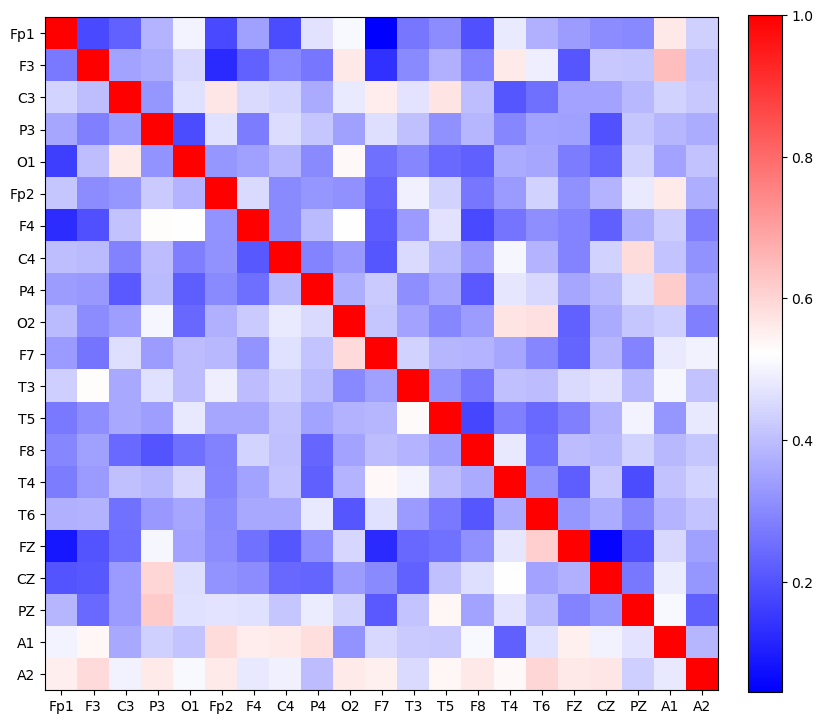

label:  [0]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(9.5,9.5))
# create an index for each tick position
my_xticks = ch_names_renamed
x = range(21)

plt.xticks(x, my_xticks)
plt.yticks(x, my_xticks)

im = ax.imshow(train_graphs[20], cmap='bwr', interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
#fig.savefig("normal1.pdf", bbox_inches='tight')

plt.show()
print("label: ", train_y[20])

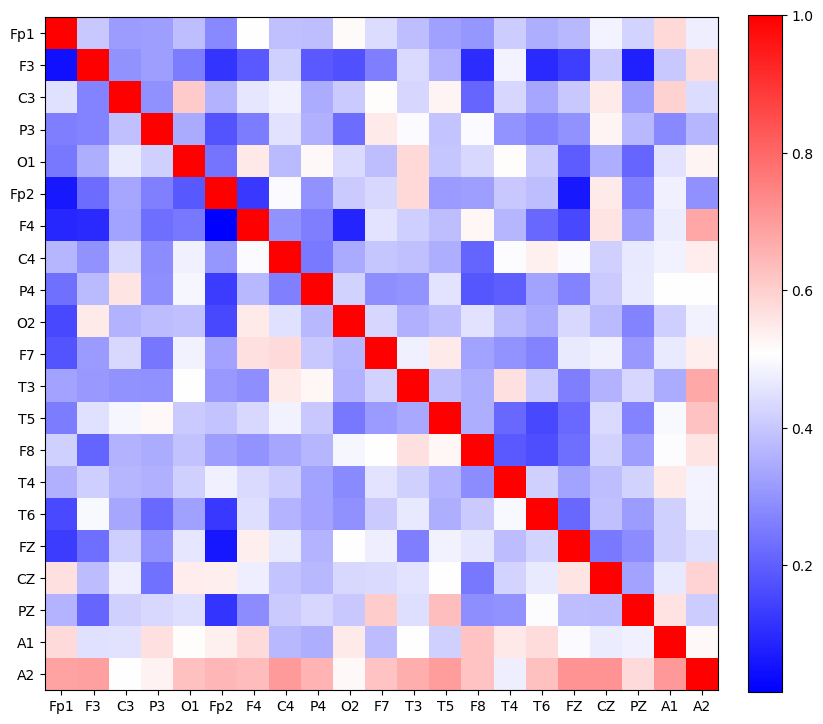

label:  [1]


In [20]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(9.5,9.5))
# create an index for each tick position
my_xticks = ch_names_renamed
x = range(21)

plt.xticks(x, my_xticks)
plt.yticks(x, my_xticks)

im = ax.imshow(train_graphs[0], cmap='bwr', interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
#fig.savefig("abnormal1.pdf", bbox_inches='tight')

plt.show()

print("label: ", train_y[0])

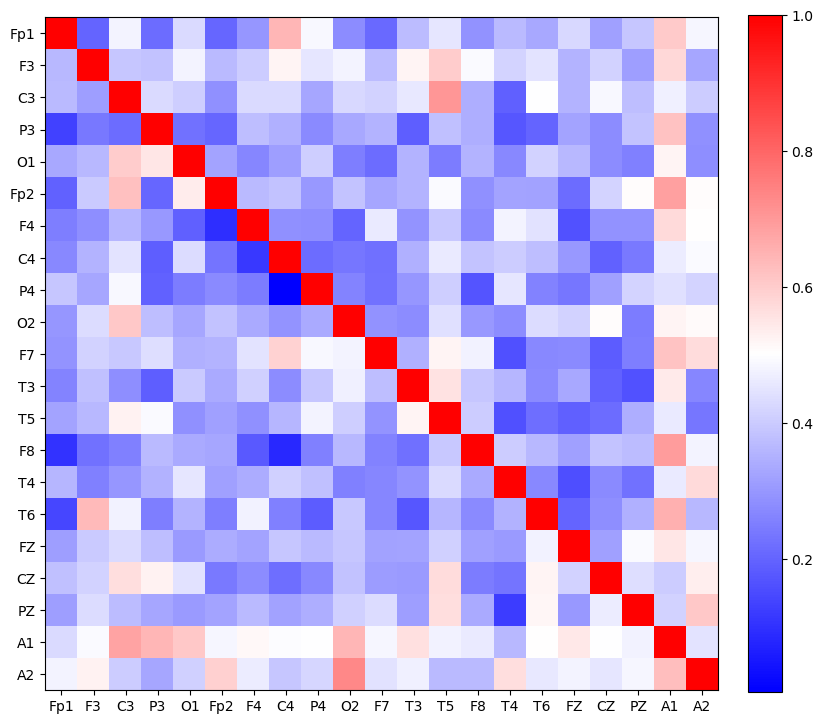

label:  [1]


In [21]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(9.5,9.5))
# create an index for each tick position
my_xticks = ch_names_renamed
x = range(21)

plt.xticks(x, my_xticks)
plt.yticks(x, my_xticks)

im = ax.imshow(train_graphs[6], cmap='bwr', interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
#fig.savefig("abnormal2.pdf", bbox_inches='tight')

plt.show()

print("label: ", train_y[6])

In [36]:
#np.save("../caueeg_features/conn_data/gc/train_X.npy", train_X)
#np.save("../caueeg_features/conn_data/gc/test_X.npy", test_X)
#np.save("../caueeg_features/conn_data/gc/train_y.npy", train_y)
#np.save("../caueeg_features/conn_data/gc/test_y.npy", test_y)
#np.save("../caueeg_features/conn_data/gc/train_graphs1.npy", train_graphs)
#np.save("../caueeg_features/conn_data/gc/test_graphs1.npy", test_graphs)

In [58]:
train_X = np.load("../caueeg_features/conn_data/gc/train_X.npy")
test_X = np.load("../caueeg_features/conn_data/gc/test_X.npy")
train_y = np.load("../caueeg_features/conn_data/gc/train_y.npy")
test_y = np.load("../caueeg_features/conn_data/gc/test_y.npy")
train_graphs = np.load("../caueeg_features/conn_data/gc/train_graphs.npy")
test_graphs = np.load("../caueeg_features/conn_data/gc/test_graphs.npy")

In [59]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

check_symmetric(train_graphs[0])

False

In [60]:
train_X = train_X[:, :, :7]
test_X = test_X[:, :, :7]

In [61]:
import torch

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import copy

def data_loader(features, graphs, labels, device, batch_size, shuffle=True):
    features, graphs, labels = torch.Tensor(features), torch.Tensor(graphs), torch.Tensor(labels)
    data = torch.utils.data.TensorDataset(features, graphs, labels)
    del features
    del labels
    data_iter = torch.utils.data.DataLoader(data, batch_size, shuffle=shuffle)
    del data
    return data_iter

def standardize_data(train_X, test_X):
 
    train_X_std = copy.deepcopy(train_X)
    test_X_std = copy.deepcopy(test_X)
    
    for i in tqdm(range(train_X.shape[1])):
        for j in range(train_X.shape[2]):
            min_ = np.min(train_X[:, i, j])
            max_ = np.max(train_X[:, i, j])
            train_X_std[:, i, j] = (train_X[:, i, j] - min_)/(max_ - min_)
            test_X_std[:, i, j] = (test_X[:, i, j] - min_)/(max_ - min_)

    return train_X_std, test_X_std

In [62]:
train_X.shape, test_X.shape

((1243, 21, 7), (136, 21, 7))

In [63]:
train_X.max(), test_X.max(), train_X.min(), test_X.min()

(81496.0, 68882.0, -3.124588730843384, -3.303999952627726)

In [64]:
train_X, test_X = standardize_data(train_X, test_X)

train_X.shape

100%|███████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 3313.91it/s]


(1243, 21, 7)

In [65]:
import copy

def uniform(train_graphs, test_graphs):
    out_train = copy.deepcopy(train_graphs)
    out_test = copy.deepcopy(test_graphs)

    min_A = train_graphs.min()
    max_A = train_graphs.max()
    out_train = (train_graphs - min_A)/(max_A - min_A)
    out_test = (test_graphs - min_A)/(max_A - min_A)

    return out_train, out_test

train_graphs, test_graphs = uniform(train_graphs, test_graphs)

In [66]:
train_X.max(), test_X.max(), train_X.min(), test_X.min()

(1.0, 1.0213751089585013, 0.0, -0.07550053071565214)

In [67]:
train_graphs.max(), train_graphs.min()

(1.0, 0.0)

In [68]:
test_graphs.max(), test_graphs.min()

(1.0, 0.0006806849008028711)

In [69]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, auc, roc_auc_score

def evaluate_model(model, loss_func, data_iter):
    model.eval()
    loss_sum, n = 0, 0
    with torch.no_grad():
        for x, A, y in data_iter:
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred,y)
            loss_sum += loss.item()
            n += 1
        return loss_sum / n
    
def cal_accuracy(model, data_iter):
    ytrue = []
    ypreds = []
    y_score = []
    model.eval()
    with torch.no_grad():
        for x, A, y in data_iter:
            x = x.float()
            A = A.float()
            yhat = model(x, A)
            
            yhat_labels = np.argmax(yhat, -1)
            y_labels = np.argmax(y, -1)
            
            y_score.extend(np.max(F.softmax(yhat, dim=1).numpy(), -1))
            ytrue.extend(list(y_labels.numpy()))
            ypreds.extend([int(yhat_i) for yhat_i in yhat_labels])
    
    return (accuracy_score(ytrue, ypreds), 
            confusion_matrix(ytrue, ypreds), 
            precision_score(ytrue, ypreds, zero_division=0), 
            recall_score(ytrue, ypreds, zero_division=0),
            f1_score(ytrue, ypreds,  zero_division=0))

# GC

In [31]:
#%%capture
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch
from model import ChebNetGCN


NUM_EPOCHS = 1000
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

loss_func = nn.BCEWithLogitsLoss()

all_train_losses = []
all_val_losses = []
all_train_f1 = []
all_val_f1 = []

skf = KFold(n_splits=5, shuffle=True)
skf.get_n_splits(train_X, train_y)

print("Training Model....")
for i, (train_index, val_index) in enumerate(skf.split(train_X, train_y)):
    
    model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_X_subset = train_X[train_index]
    train_y_subset = train_y[train_index]
    train_graphs_subset = train_graphs[train_index]
    val_X = train_X[val_index]
    val_y = train_y[val_index]
    val_graphs_subset = train_graphs[val_index]

    encoder = OneHotEncoder()
    train_y_subset = encoder.fit_transform(train_y_subset).toarray()
    val_y = encoder.transform(val_y).toarray()

    batch_size = 128
    train_iter = data_loader(train_X_subset ,train_graphs_subset, train_y_subset, DEVICE, BATCH_SIZE, shuffle=True)
    val_iter = data_loader(val_X, val_graphs_subset, val_y, DEVICE, BATCH_SIZE, shuffle=False)

    kfold_train_loss = []
    kfold_val_loss = []
    kfold_train_f1 = []
    kfold_val_f1 = []
    for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss#.item()
            loss.backward()
            optimizer.step()

        train_loss = evaluate_model(model, loss_func, train_iter)
        val_loss = evaluate_model(model, loss_func, val_iter)
        train_f1 = cal_accuracy(model, train_iter)[-1]
        val_f1 = cal_accuracy(model, val_iter)[-1]
        kfold_train_loss.append(train_loss)
        kfold_val_loss.append(val_loss)
        kfold_train_f1.append(train_f1)
        kfold_val_f1.append(val_f1)

    all_train_losses.append(kfold_train_loss)
    all_val_losses.append(kfold_val_loss)
    all_train_f1.append(kfold_train_f1)
    all_val_f1.append(kfold_val_f1)

Training Model....


100%|█████████████████████████████████████████████████████████████| 1000/1000 [06:37<00:00,  2.52it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


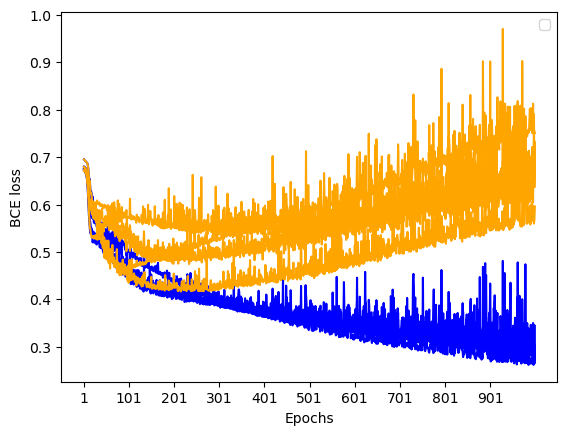

In [32]:
import matplotlib.pyplot as plt

all_val_losses = np.moveaxis(np.array(all_val_losses), 0, 1)
all_train_losses = np.moveaxis(np.array(all_train_losses), 0, 1)
plt.plot(all_train_losses, color='blue')
plt.plot(all_val_losses, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(1, 1001, 100))
plt.ylabel("BCE loss")
plt.legend(loc="upper right")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


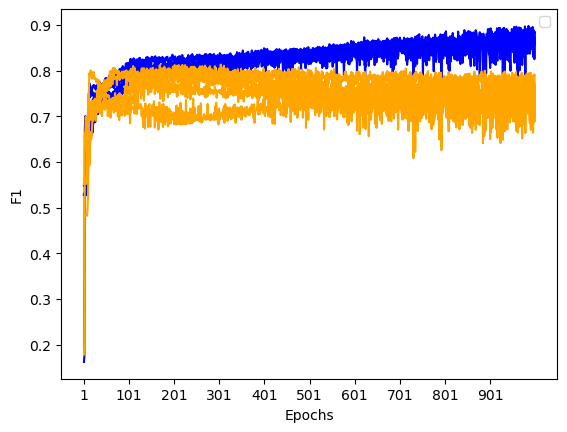

In [33]:
all_val_f1 = np.moveaxis(np.array(all_val_f1), 0, 1)
all_train_f1 = np.moveaxis(np.array(all_train_f1), 0, 1)
plt.plot(all_train_f1, color='blue')
plt.plot(all_val_f1, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(1, 1001, 100))
plt.ylabel("F1")
plt.legend(loc="upper right")
plt.show()

In [49]:
#%%capture
from tqdm import tqdm
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch
from model import ChebNetGCN


print("Training Model....")
NUM_EPOCHS = 200
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
encoder = OneHotEncoder()
train_y_ohe = encoder.fit_transform(train_y).toarray()
test_y_ohe = encoder.fit_transform(test_y).toarray()
    
train_iter = data_loader(train_X , train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
test_iter = data_loader(test_X , test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)
  
for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    loss_sum, n = 0.0, 0
    model.train()
    for t, (x, A, y) in enumerate(train_iter):
        optimizer.zero_grad()
        x = x.float()
        A = A.float()
        y_pred = model(x, A)
        loss = loss_func(y_pred, y)
        loss_sum += loss
        loss.backward()
        optimizer.step()

Training Model....


100%|███████████████████████████████████████████████████████████████| 200/200 [00:34<00:00,  5.85it/s]


In [50]:
test_acc = cal_accuracy(model, test_iter)
print("Accuracy: ", test_acc[0])
print("Precision: ", test_acc[2])
print("Recall: ", test_acc[3])
print("F1: ", test_acc[4])
print("Confusion Matrix: ", test_acc[1])

Accuracy:  0.8308823529411765
Precision:  0.8602150537634409
Recall:  0.8888888888888888
F1:  0.8743169398907102
Confusion Matrix:  [[33 13]
 [10 80]]


Here we run the model 20 times to record the stability

In [70]:
#%%capture
print("Training Model....")
import random
#from model import ChebNetGCN
NUM_EPOCHS = 200
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

test_accuaries = []
NUM_MODELS = 20

for model_idx in tqdm(range(NUM_MODELS)):
    seed = random.randint(0, 100000)
    torch.manual_seed(seed)
    model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)
    loss_func = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    encoder = OneHotEncoder()
    train_y_ohe = encoder.fit_transform(train_y).toarray()
    test_y_ohe = encoder.fit_transform(test_y).toarray()

    train_iter = data_loader(train_X , train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
    test_iter = data_loader(test_X , test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)

    for epoch in range(1, NUM_EPOCHS + 1):
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss
            loss.backward()
            optimizer.step()
            
    test_acc = cal_accuracy(model, test_iter)
    test_accuaries.append([test_acc[0], test_acc[2], test_acc[3], test_acc[4]])
test_accuaries = np.array(test_accuaries)

Training Model....


100%|█████████████████████████████████████████████████████████████████| 20/20 [11:31<00:00, 34.58s/it]


In [72]:
print("Accuracy: ", test_accuaries[:, 0].std())
print("Precision: ", test_accuaries[:, 1].std())
print("Recall: ", test_accuaries[:, 2].std())
print("F1: ", test_accuaries[:, 3].std())

Accuracy:  0.03222736323648694
Precision:  0.011598355763207967
Recall:  0.05491576040391993
F1:  0.027762906310712206


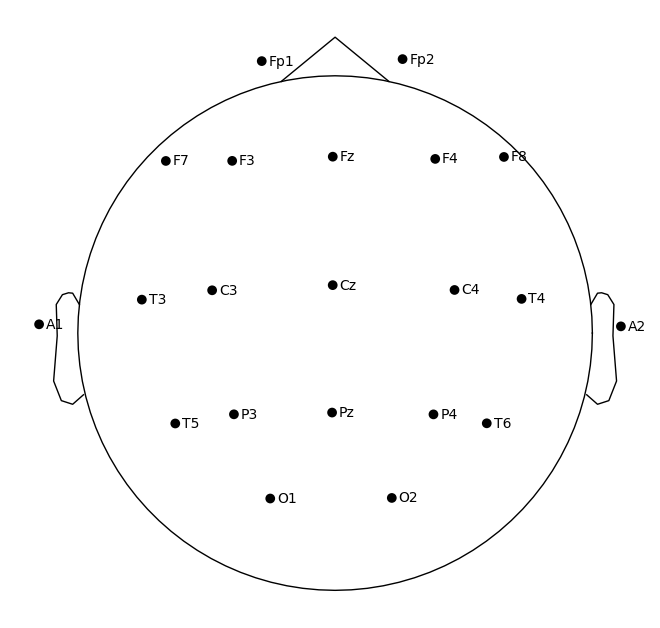

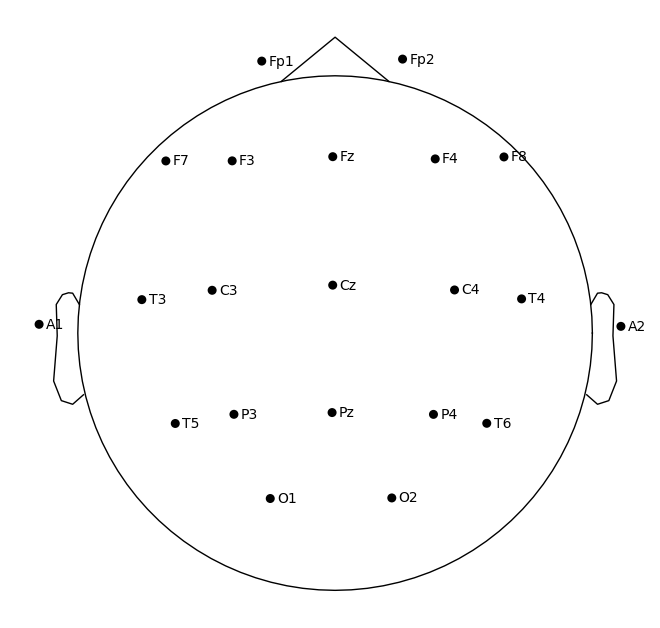

In [38]:
# Form the 10-20 montage
mont1020 = mne.channels.make_standard_montage('standard_1020')
# Choose what channels you want to keep 
# Make sure that these channels exist e.g. T1 does not exist in the standard 10-20 EEG system!
kept_channels = ch_names_renamed
ind = []
kept_channels = [ch.lower() for ch in kept_channels]
for i, channel in enumerate(mont1020.ch_names):
    if channel.lower() in kept_channels:
        ind.append(i)
#ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_new = mont1020.copy()
# Keep only the desired channels
mont1020_new.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]
# Keep the first three rows as they are the fiducial points information
mont1020_new.dig = mont1020.dig[0:3]+kept_channel_info
#mont1020.plot()
mont1020_new.plot()

In [39]:
# electrode positions for the graph nodes
# based on the international 10-20 system
node_positions = {'FP1': (-0.4, 0.45), 'FP2': (0.4, 0.45),
                  'F7': (-1.25, 0.33), 'F3': (-0.65, 0.255),
                  'FZ': (0.0, 0.225), 'F4': (0.65, 0.255),
                  'F8': (1.25, 0.33), 'T3': (-1.5, 0.0),
                  'C3': (-0.75, 0.0), 'CZ': (0.0, 0.0),
                  'C4': (0.75, 0.0), 'T4': (1.5, 0.0),
                  'T5': (-1.25, -0.33), 'P3': (-0.65, -0.255),
                  'PZ': (0.0, -0.225), 'P4': (0.65, -0.255),
                  'T6': (1.25, -0.33), 'O1': (-0.4, -0.45),
                  'O2': (0.4, -0.45) 
                 }

nodelist = node_positions.keys()

## Uncertainty Analysis

## Corr

In [124]:
import numpy as np

def build_graphs(raw_data):
    
    fs = 100
    
    data_graphs = []
    
    for file in tqdm(raw_data):
        
        data = mne.io.read_raw(file, verbose=False, preload=True)
        ch_names = data.ch_names
        #data.resample(sfreq=100)
        data.filter(l_freq=0.5, h_freq=47, verbose=False)
        #data = mne.make_fixed_length_epochs(data, duration=5, overlap=1, verbose=False)
        data = data.get_data()*1e6
          
        corr = []
        for i in range(21):
            corr1 = []
            for j in range(21):
                corr1.append(np.correlate(data[i], data[j])[0])
            corr.append(corr1)
        data_graphs.append(corr)    
        
    data_graphs = np.array(data_graphs)
    
    return data_graphs

train_corr_graphs = build_graphs(train_data_files)
test_corr_graphs = build_graphs(test_data_files)

100%|███████████████████████████████████████████████████████████████| 136/136 [00:15<00:00,  8.94it/s]


In [73]:
#np.save("../caueeg_features/conn_data/corr/train_graphs.npy", train_corr_graphs)
#np.save("../caueeg_features/conn_data/corr/test_graphs.npy", test_corr_graphs)

train_graphs = np.load("../caueeg_features/conn_data/corr/train_graphs.npy")
test_graphs = np.load("../caueeg_features/conn_data/corr/test_graphs.npy")

In [74]:
train_graphs, test_graphs = uniform(train_graphs, test_graphs)

In [75]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

check_symmetric(train_graphs[0])

True

In [77]:
%%capture
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch
from model import ChebNetGCN


NUM_EPOCHS = 1000
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

loss_func = nn.BCEWithLogitsLoss()

all_train_losses = []
all_val_losses = []
all_train_f1 = []
all_val_f1 = []

skf = KFold(n_splits=5, shuffle=True)
skf.get_n_splits(train_X, train_y)

print("Training Model....")
for i, (train_index, val_index) in enumerate(skf.split(train_X, train_y)):
    
    model = ChebNetGCN(NUM_NODE_FEATURES, 128, NUM_CHANNELS, 32, NUM_CLASSES)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_X_subset = train_X[train_index]
    train_y_subset = train_y[train_index]
    train_graphs_subset = train_graphs[train_index]
    val_X = train_X[val_index]
    val_y = train_y[val_index]
    val_graphs_subset = train_graphs[val_index]

    encoder = OneHotEncoder()
    train_y_subset = encoder.fit_transform(train_y_subset).toarray()
    val_y = encoder.transform(val_y).toarray()

    batch_size = 128
    train_iter = data_loader(train_X_subset ,train_graphs_subset, train_y_subset, DEVICE, BATCH_SIZE, shuffle=True)
    val_iter = data_loader(val_X, val_graphs_subset, val_y, DEVICE, BATCH_SIZE, shuffle=False)

    kfold_train_loss = []
    kfold_val_loss = []
    kfold_train_f1 = []
    kfold_val_f1 = []
    for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss#.item()
            loss.backward()
            optimizer.step()

        train_loss = evaluate_model(model, loss_func, train_iter)
        val_loss = evaluate_model(model, loss_func, val_iter)
        train_f1 = cal_accuracy(model, train_iter)[-1]
        val_f1 = cal_accuracy(model, val_iter)[-1]
        kfold_train_loss.append(train_loss)
        kfold_val_loss.append(val_loss)
        kfold_train_f1.append(train_f1)
        kfold_val_f1.append(val_f1)

    all_train_losses.append(kfold_train_loss)
    all_val_losses.append(kfold_val_loss)
    all_train_f1.append(kfold_train_f1)
    all_val_f1.append(kfold_val_f1)

UsageError: %%capture is a cell magic, but the cell body is empty.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


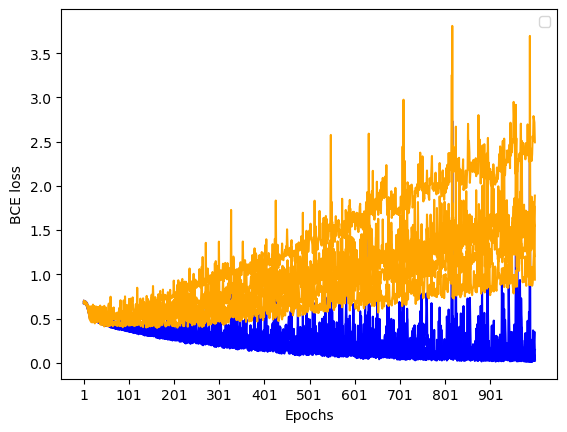

In [44]:
import matplotlib.pyplot as plt

all_val_losses = np.moveaxis(np.array(all_val_losses), 0, 1)
all_train_losses = np.moveaxis(np.array(all_train_losses), 0, 1)
plt.plot(all_train_losses, color='blue')
plt.plot(all_val_losses, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(1, 1001, 100))
plt.ylabel("BCE loss")
plt.legend(loc="upper right")
plt.show()

In [56]:
#%%capture
from tqdm import tqdm
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch
from model import ChebNetGCN


print("Training Model....")
NUM_EPOCHS = 200
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
encoder = OneHotEncoder()
train_y_ohe = encoder.fit_transform(train_y).toarray()
test_y_ohe = encoder.fit_transform(test_y).toarray()
    
train_iter = data_loader(train_X, train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
test_iter = data_loader(test_X, test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)
  
for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    loss_sum, n = 0.0, 0
    model.train()
    for t, (x, A, y) in enumerate(train_iter):
        optimizer.zero_grad()
        x = x.float()
        A = A.float()
        y_pred = model(x, A)
        loss = loss_func(y_pred, y)
        loss_sum += loss
        loss.backward()
        optimizer.step()

Training Model....


100%|███████████████████████████████████████████████████████████████| 200/200 [00:34<00:00,  5.85it/s]


In [57]:
test_acc = cal_accuracy(model, test_iter)
print("Accuracy: ", test_acc[0])
print("Precision: ", test_acc[2])
print("Recall: ", test_acc[3])
print("F1: ", test_acc[4])
print("Confusion Matrix: ", test_acc[1])

Accuracy:  0.8161764705882353
Precision:  0.8571428571428571
Recall:  0.8666666666666667
F1:  0.861878453038674
Confusion Matrix:  [[33 13]
 [12 78]]


In [78]:
#%%capture
print("Training Model....")
import random
#from model import ChebNetGCN
NUM_EPOCHS = 200
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

test_accuaries = []
NUM_MODELS = 20

for model_idx in tqdm(range(NUM_MODELS)):
    seed = random.randint(0, 100000)
    torch.manual_seed(seed)
    model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)
    loss_func = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    encoder = OneHotEncoder()
    train_y_ohe = encoder.fit_transform(train_y).toarray()
    test_y_ohe = encoder.fit_transform(test_y).toarray()

    train_iter = data_loader(train_X, train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
    test_iter = data_loader(test_X, test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)

    for epoch in range(1, NUM_EPOCHS + 1):
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss
            loss.backward()
            optimizer.step()
            
    test_acc = cal_accuracy(model, test_iter)
    test_accuaries.append([test_acc[0], test_acc[2], test_acc[3], test_acc[4]])
test_accuaries = np.array(test_accuaries)

Training Model....


100%|█████████████████████████████████████████████████████████████████| 20/20 [14:48<00:00, 44.44s/it]


In [79]:
print("Accuracy: ", test_accuaries[:, 0].std())
print("Precision: ", test_accuaries[:, 1].std())
print("Recall: ", test_accuaries[:, 2].std())
print("F1: ", test_accuaries[:, 3].std())

Accuracy:  0.02281486247661796
Precision:  0.017300977187318642
Recall:  0.0311259885062921
F1:  0.017228106578392643
